## Load relevant packages

In [1]:
# Import all the required packages
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from copy import deepcopy
import re
%matplotlib inline

## Load relevant data files

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
# For each data file, we write which column contains the information we want to predict
topredictcolumn= ["Survived"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

# Temporary work

This particular problem is a classification problem; we are not trying to obtain the value of some parameter, e.g. how much a customer will spend in the future.

However, it might still be useful to try and predict such parameters, e.g. the age of passengers. This might improve survival predictions, but regarless it is a good exercise to do.

In [3]:
thedataframe = deepcopy(alldataframes[0])
datacateg = {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C",
             'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
             'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
uselesscols = ["Name", "Ticket"]
dictofunknown = {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
                 "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", 
                 "Age": alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0], 
                 "Nationality": "Unknown"}

### Functions for making predictions based on given model
(For regression and classification through regression)

In [4]:
# Returns the intercept, parameters, Rscore (where 1.0 is perfect prediction, and percentage of cases
# correctly predicted. The final two are given as tuple (score, errorbarsonscore). X is the data we use 
# to predict y; predictionmethod is the name of our model, e.g. linear_model.LinearRegression; rounddecimals
# equals the number of decimals allowed for our prediction, e.g. when predicting integers rounddecimals=0; 
# num_iterations is the number of times we run the function to obtain the parameters, and kwargs are any 
# additional optional parameters we want to pass on to predictionmethod.
def getParametersAndPredictionScore(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    parameters = []
    intercept = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            parameters.append(predictor.coef_)
            intercept.append(predictor.intercept_)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    parameters = np.mean(parameters, axis=0)
    intercept = np.mean(intercept)
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (intercept, parameters, score, predictedpercent)
    else:
        toreturn = (intercept, parameters, score)
    return toreturn

# Returns the prediction accuracy (+/- errorbars on the accuracy) when classifying "at random", i.e. 
# by always predicting the same thing for all the elements. We try by predicting the mean, or the 
# median, or the most frequently occurring element
def randomPrediction(y, rounddecimals="none", num_iterations=1):
    meanscore = []
    medianscore = []
    mostfrequentscore = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            ytrain, ytest = y[trainindex], y[testindex]
            mean = np.mean(ytrain)
            median = np.median(ytrain)
            mostfrequent = max(set(list(y)), key=list(ytrain).count)
            if rounddecimals!="none":
                mean = np.round(mean, decimals=rounddecimals)
            meanscore.append((ytest==mean).mean())
            medianscore.append((ytest==median).mean())
            mostfrequentscore.append((ytest==mostfrequent).mean())
    meanscore = (np.mean(meanscore), np.std(meanscore))
    medianscore = (np.mean(medianscore), np.std(medianscore))
    mostfrequentscore = (np.mean(mostfrequentscore), np.std(mostfrequentscore))
    allscores = [meanscore[0], medianscore[0], mostfrequentscore[0]]
    return [meanscore, medianscore, mostfrequentscore][allscores.index(max(allscores))]

#### Helper functions

In [5]:
def transformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = np.sqrt(outputdata[outputdata>0])
        outputdata[outputdata<0] = -np.sqrt(-outputdata[outputdata<0])
    if transform=="log":
        outputdata[outputdata>1] = np.log(outputdata[outputdata>1])+1
        outputdata[outputdata<-1] = -np.log(-outputdata[outputdata<-1])-1
    return outputdata

def inverseTransformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = outputdata[outputdata>0]**2
        outputdata[outputdata<0] = -((-outputdata[outputdata<0])**2)
    if transform=="log":
        outputdata[outputdata>1] = np.e**(outputdata[outputdata>1]-1)
        outputdata[outputdata<-1] = -(np.e**(-outputdata[outputdata<-1] -1))
    return outputdata

#This function removes those rows in "inputdataframe" where data was generated automatially 
# in the column "columnofinterest". "dictofunknown" contains the information on what data was
# generated automatically.
def removeAutogeneratedData(inputdataframe, columnsofinterest, dictofunknown):
    if type(columnsofinterest)==str:
        allcolumnsofinterest = [columnsofinterest]
    else:
        allcolumnsofinterest = columnsofinterest
    outputdataframe = deepcopy(inputdataframe)
    for col in allcolumnsofinterest:
        if col in dictofunknown:
            outputdataframe = outputdataframe[outputdataframe[col]!= dictofunknown[col]]
    return outputdataframe

# Helper function that takes a model, e.g. linear_model.LinearRegression,
# and returns the name of that model, e.g. "LinearRegression"
def getModelName(currentmodel):
    modelname = str(currentmodel)
    modelname = modelname[modelname.rfind(".")+1:]
    extracharacters = re.search("[^a-zA-z]",modelname)
    if type(extracharacters)!=type(None):
        modelname = modelname[:extracharacters.start()]
    return modelname

### Implement all linear regressions

In [6]:
def tryAllLinearRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LinearRegression, linear_model.RidgeCV, linear_model.LassoCV, 
                      linear_model.BayesianRidge]
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        print modelname
        if "n_alphas" in model().get_params():
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, n_alphas=3,
                                                        classifier=classifier, transform=transform)
        else:
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, classifier=classifier,
                                                        transform=transform)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

# Makes a scatterplot of the error in prediction, versus the predicted value, to see if there
# is any heteroscedasticity, i.e. to see if the error bars of our prediction depend on the value
# of the prediction. Returns the R^2 value of the prediction.
def plotErrors(thedataframe, topredict, frompredict, chosenmodel, dictofregressions, 
               rounddecimals="none", minvalue="none", maxvalue="none", ax="none", alpha=0.3, transform="none"):
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    if transform!="none":
        X = transformData(X, transform=transform)
    coefficients = dictofregressions[chosenmodel][1]
    intercept = dictofregressions[chosenmodel][0]
    prediction = np.dot(X,coefficients) + intercept
    if transform!="none":
        prediction = inverseTransformData(prediction, transform=transform)
    if rounddecimals!="none":
        prediction = np.round(prediction, decimals=rounddecimals)
    if minvalue!="none":
        prediction[prediction < minvalue] = minvalue
    if maxvalue!="none":
        prediction[prediction > maxvalue] = maxvalue
    if ax=="none":
        plt.scatter(prediction, prediction - y, alpha=alpha)
        plt.xlabel("Predicted " + topredict)
        plt.ylabel("Error in prediction")
        plt.show()
    else:
        ax.scatter(prediction, prediction - y, alpha=alpha)
        ax.set_xlabel("Predicted " + topredict)
        ax.set_ylabel("Error in prediction")
    print "Mean: %f" %np.mean(prediction - y)
    print "Std: %f" %np.std(prediction - y)
    print "R^2: %f" %(np.var(prediction) / np.var(y))

#### Helper functions

In [7]:
def makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown):
    tousedataframe = removeAutogeneratedData(thedataframe, frompredict + [topredict], dictofunknown)
    X = tousedataframe[frompredict].as_matrix()
    y = tousedataframe[topredict].as_matrix()
    return (X,y)

### Functions for using regressions to fill in unknown data

In [8]:
# Makes a dataframe where the values of topredict have been predicted using frompredict, with the regression 
# model called chosenmodel (a string). For this we need to have found all regressions, placed in the variable
# dictofregressions.
def incorporateRegressionPrediction(inputdataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                    rounddecimals="none", minvalue="none", maxvalue="none", transform="none"):
    thedataframe = deepcopy(inputdataframe)
    if topredict in dictofunknown:
        topredictframe = thedataframe[thedataframe[topredict]==dictofunknown[topredict]]
    else:
        topredictframe = thedataframe[thedataframe[topredict].isnull()]
    ind = topredictframe.index
    dataX = topredictframe[frompredict].as_matrix()
    if transform!="none":
        dataX = transformData(dataX, transform=transform)
    if len(dataX) > 0:
        coefficients = dictofregressions[chosenmodel][1]
        intercept = dictofregressions[chosenmodel][0]
        prediction = np.dot(dataX,coefficients) + intercept
        if transform!="none":
            prediction = inverseTransformData(prediction, transform=transform)
        if rounddecimals!="none":
            prediction = np.round(prediction, decimals=rounddecimals)
        if minvalue!="none":
            prediction[prediction < minvalue] = minvalue
        if maxvalue!="none":
            prediction[prediction > maxvalue] = maxvalue
        thedataframe.loc[ind, topredict] = prediction
    return thedataframe

### Use linear regression for missing data

After having tried various options, it seems like using transform="log" we're able to avoid most of the heteroscedasticity we otherwise get with a straightforward linear regression.

In [9]:
topredict = "Age"
frompredict = ["Survived", "SibSp", "Parch", "Fare"]
tousedataframe = deepcopy(thedataframe)
transform = "log"

linearregressions = tryAllLinearRegressions(tousedataframe, topredict, frompredict,
                                            dictofunknown=dictofunknown, printout=True, num_iterations=100, 
                                            rounddecimals="none", classifier=False, transform=transform)

LinearRegression
	The score on the fit is 0.234814 ± 0.083242 (1.0 is perfect)
RidgeCV
	The score on the fit is 0.238904 ± 0.069174 (1.0 is perfect)
LassoCV
	The score on the fit is 0.238177 ± 0.080444 (1.0 is perfect)
BayesianRidge
	The score on the fit is 0.239478 ± 0.074581 (1.0 is perfect)


### Check heteroscedasticity of fit

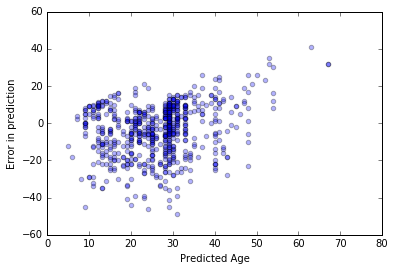

Mean: -3.428812
Std: 13.783246
R^2: 0.424820


In [10]:
chosenmodel = "LinearRegression"
dictofregressions = linearregressions
rounddecimals=0
minvalue=0
maxvalue=100

plotErrors(thedataframe, topredict, frompredict, chosenmodel, dictofregressions,
           rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, ax="none", transform=transform)

### Make new datafram with predicted values

In [11]:
newdataframe = incorporateRegressionPrediction(thedataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                               rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, 
                                               transform=transform)

In [14]:
topredict = "Survived"
frompredict = ["Age", "SibSp", "Parch", "Fare"]
tousedataframe = deepcopy(thedataframe)
transform = "none"
rounddecimals=0

linearregressions = tryAllLinearRegressions(tousedataframe, topredict, frompredict,
                                            dictofunknown=dictofunknown, printout=True, num_iterations=100, 
                                            rounddecimals=rounddecimals, classifier=True, transform=transform)

LinearRegression
	The score on the fit is 0.070250 ± 0.042442 (1.0 is perfect)
	The percentage of correct identifications is: 0.661737 ± 0.037592
	         Benchmark from random prediction is: 0.591242 ± 0.034366
RidgeCV
	The score on the fit is 0.071486 ± 0.040342 (1.0 is perfect)
	The percentage of correct identifications is: 0.661062 ± 0.038282
	         Benchmark from random prediction is: 0.591242 ± 0.034366
LassoCV
	The score on the fit is 0.069944 ± 0.039153 (1.0 is perfect)
	The percentage of correct identifications is: 0.658438 ± 0.039246
	         Benchmark from random prediction is: 0.591242 ± 0.034366
BayesianRidge
	The score on the fit is 0.063921 ± 0.037960 (1.0 is perfect)
	The percentage of correct identifications is: 0.638918 ± 0.038708
	         Benchmark from random prediction is: 0.591242 ± 0.034366


In [15]:
topredict = "Survived"
frompredict = ["Age", "SibSp", "Parch", "Fare"]
tousedataframe = deepcopy(thedataframe)
transform = "none"
rounddecimals=0

linearregressions = tryAllLinearRegressions(newdataframe, topredict, frompredict,
                                            dictofunknown=dictofunknown, printout=True, num_iterations=100, 
                                            rounddecimals=rounddecimals, classifier=True, transform=transform)

LinearRegression
	The score on the fit is 0.080902 ± 0.035215 (1.0 is perfect)
	The percentage of correct identifications is: 0.679197 ± 0.032954
	         Benchmark from random prediction is: 0.610730 ± 0.033079
RidgeCV
	The score on the fit is 0.079951 ± 0.041414 (1.0 is perfect)
	The percentage of correct identifications is: 0.679564 ± 0.036414
	         Benchmark from random prediction is: 0.610730 ± 0.033079
LassoCV
	The score on the fit is 0.081313 ± 0.035187 (1.0 is perfect)
	The percentage of correct identifications is: 0.678055 ± 0.034028
	         Benchmark from random prediction is: 0.610730 ± 0.033079
BayesianRidge
	The score on the fit is 0.077957 ± 0.034517 (1.0 is perfect)
	The percentage of correct identifications is: 0.673092 ± 0.035371
	         Benchmark from random prediction is: 0.610730 ± 0.033079


REGRESSION MODELS:
 - when going from quant to quant
 - if descrete, just round the numbers
 - don't treat it like a classification: when evaluating errors I should not count number of cases I hit exactly right
 - I should try all versions of linear regressions, then nonlinear ones
 - think about resizing data? Maybe that's more useful for feature selection, where the normalized data forces parameters to all be "worth" equal and we can assess which parameters are more important.

GETTING QUANT FROM QUANT: regression may be best. I sohuld also try the more advanced methods of SVM and random forests
GETTING QUANT FROM CATEG/ORD: the more categories the better. Need to look into the classification algorithms, but it may be that I can guess the quantitiative value from the combination of categorical values. Maybe Random Forests can take in a combination of quant and categ
GETTING CATEG FROM QUANT: logistic regression could work OK. Otherwise try the other classification algorithms
GETTING CATEG FROM CATEG: again, random forests etc. could be a good tactics.


##### Still to do:
 - Make a function that takes the data, a model name, what to predict and outputs predictions for the data and how well it did
 - Make a function that does clustering
 - Make a function that does feature engineering
 - Make plots to evaluate how well a certain prediction did (e.g. confusion matrices and ROC curves)
 - As helper-functions, might need to do bootstrapping functions etc., unless they're already in-built
 - Race models agains each other
 - Check what else we did during S2DS